In [1]:
import torch
import torch.nn as nn
import torchvision
import pandas as pd
import numpy as np
import pathlib
from torchvision import transforms as tr
import torch
from tqdm.notebook import tqdm
from PIL import Image
import torch
import torch.nn as nn
import pathlib
import pickle
import numpy as np
from torchvision.datasets import CIFAR10
import time
from torchvision import transforms as tr
import random
import os
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from IPython.display import clear_output
import telebot
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
from torch.optim import Optimizer

In [2]:
torch.manual_seed(42)
random.seed(0)
np.random.seed(42)
token_bot = ... # YOUR TG BOT TOKEN HERE
my_tg_token = ... # YOUR CHAT ID HERE
# logging validation loss and accuracy with plots via tg bot
bot = telebot.TeleBot(token_bot)

In [46]:
import torch
from torch.optim import Optimizer

class SGD_AdaptiveLR(Optimizer):

    def __init__(self, params, lr=1e-2, dampening=0, c = 0.01, w = 10, k = 0.1,
                 weight_decay=0, nesterov=False, clip=False, ):
        if lr and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        self.clip = clip
        self.iteration = -1
        self.c = c
        self.w = w
        defaults = dict(lr=lr, dampening=dampening, weight_decay=weight_decay, nesterov=nesterov,
                        c = c, w = w, k = k)
        super(SGD_AdaptiveLR, self).__init__(params, defaults)
        for group in self.param_groups:
            group.setdefault('nesterov', False)
            for p in group['params']:
                state = self.state[p]
                state['displacement'] = torch.zeros_like(p)
                state['max_grad'] = torch.zeros(1, device = p.device)
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()
        self.iteration += 1
        for group in self.param_groups:
            weight_decay = group['weight_decay']
            dampening = group['dampening']
            nesterov = group['nesterov']
            lr =  group['lr']
            c = group['c']
            w = group['w']
            k = group['k']
            vector = []
            grads = []
            param = []
            for p in group['params']:
                if p.grad is None:
                    continue
                vector.append(self.state[p]['displacement'])
                grads.append(p.grad)
                param.append(p)

            hvp = torch.autograd.grad(outputs = grads, inputs = param, grad_outputs=vector)
            with torch.no_grad():
                i = 0
                for p in group['params']:
                    if p.grad is None:
                        continue
                    state = self.state[p]
                    displacement, max_grad = state['displacement'], state['max_grad']
                    
                    with torch.no_grad():
                        d_p = p.grad
                        if weight_decay != 0:
                            d_p = d_p.add(p, alpha=weight_decay)

                        if len(state) <= 2:
                            buf = state['momentum_buffer'] = torch.clone(d_p).detach()
                            state['G'] = torch.norm(torch.clone(d_p).detach())
                            state['lr'] = k/(torch.pow((w+torch.pow(state['G'],2)),1/3))
                            state['momentum'] = c * torch.pow(state['lr'], 2)
                        else:
                            buf = state['momentum_buffer']
                            G = state['G']
                            G.add_(torch.pow(torch.norm(d_p), 2))
                            state['lr'] = k / (torch.pow((w + torch.pow(state['G'], 2)), 1 / 3))
                            state['momentum'] = c * torch.pow(state['lr'], 2)
                            buf.add_(hvp[i]).add_(displacement, alpha = weight_decay).mul_(state['momentum']).add_(d_p, alpha = 1-dampening)
                            if nesterov:
                                d_p = d_p.add(buf, alpha=state['momentum'])
                            else:
                                d_p = buf
                                
                        displacement.copy_(d_p).mul_(-state['lr'])
                        p.add_(displacement)
                        
                        
                    i += 1
                            
        return loss

In [7]:
train_transforms = tr.Compose([
            tr.RandomCrop(32, padding=4),
            tr.RandomHorizontalFlip(),
            tr.ToTensor(),
            tr.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])

val_transforms = tr.Compose([
            tr.ToTensor(),
            tr.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])


In [8]:
dataset = CIFAR10(root='D:/CIFAR10/', download=True, train=True, transform=train_transforms)
val_dataset = CIFAR10(root='D:/CIFAR10/', train=False, transform=val_transforms)


Files already downloaded and verified


In [9]:
batch_size = 256

In [10]:
train_dl = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True, pin_memory=True)
val_dl = torch.utils.data.DataLoader(val_dataset, batch_size, pin_memory=True)

In [11]:
@torch.no_grad()
def top_k_accuracy(y_pred, y_true, k=1):
    _, ind = y_pred.detach().topk(k, dim=1)
    return ind.eq(y_true.view(-1, 1)).float().sum(1).mean().item()

In [12]:
@torch.no_grad()
def val_epoch(model, dl, criterion):
    mean_loss    = []
    mean_acc     = []
    mean_top5acc = []
    for x, y in tqdm(dl, desc='Validation'):
        try:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            predict = model(x)
            loss = criterion(predict, y)

            mean_loss.append(loss.item())
            mean_acc.append(top_k_accuracy(predict, y))
            mean_top5acc.append(top_k_accuracy(predict, y, k=5))
        except KeyboardInterrupt:
            raise KeyboardInterrupt
        finally:
            x = x.cpu()
            y = y.cpu()
            del x
            del y
    
    return np.mean(mean_loss), np.mean(mean_acc), np.mean(mean_top5acc)


def train_epoch(model, dl, criterion, optimizer):
    mean_loss    = []
    mean_acc     = []
    mean_top5acc = []
    for x, y in tqdm(dl, desc='Training'):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        try:
            predict = model(x)
            loss = criterion(predict, y)

            optimizer.zero_grad()
            loss.backward(create_graph = True)
            optimizer.step()

            mean_loss.append(loss.item())
            mean_acc.append(top_k_accuracy(predict, y))
            mean_top5acc.append(top_k_accuracy(predict, y, k=5))
        except KeyboardInterrupt:
            raise KeyboardInterrupt
        finally:
            x = x.cpu()
            y = y.cpu()
            del x
            del y
    
    return np.mean(mean_loss), np.mean(mean_acc), np.mean(mean_top5acc)

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

from torch.autograd import Variable

__all__ = ['ResNet', 'resnet20', 'resnet32', 'resnet44', 'resnet56', 'resnet110', 'resnet1202']

def _weights_init(m):
    classname = m.__class__.__name__

    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1,):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = LambdaLayer(lambda x:
                                        F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))


    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def resnet20():
    return ResNet(BasicBlock, [3, 3, 3])

In [20]:
def run_experiment(model, optim):
    start = time.time()
    torch.cuda.empty_cache()

    criterion = nn.CrossEntropyLoss()
    epochs = 130

    scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, [80, 120])
    
    exp_path = pathlib.Path(f'results/SGDHessAdaptiveLr')
    (exp_path / "checkpoints").mkdir(parents=True, exist_ok=True)
    loss, acc, fig = run_learning(model, train_dl, val_dl, criterion, optim, epochs, exp_path / "checkpoints", scheduler=scheduler)

    print(f'{(time.time() - start)/3600:.2f} hours')



In [16]:
def run_learning(model, train_dl, val_dl, criterion, optimizer, epochs, path, scheduler=None):
    plt.style.use('fivethirtyeight')
    model = model.to(DEVICE)
    train_loss    = []
    train_top5acc = []
    train_top1acc = []
    val_loss      = []
    val_top5acc   = []
    val_top1acc   = []
    test_loss     = []
    test_top1acc  = []
    test_top5acc  = []
    try:
        for e in range(epochs):
            model.train()
            t_loss, t_acc, t_5acc = train_epoch(model, train_dl, criterion, optimizer)
            model.eval()
            v_loss, v_acc, v_5acc = val_epoch(model, val_dl, criterion)
            
            clear_output(True)
            if scheduler is not None:
                if not isinstance(scheduler, list):
                    scheduler = [scheduler]
                for s in scheduler:
                    if isinstance(s, torch.optim.lr_scheduler.ReduceLROnPlateau):
                        s.step(v_loss)
                    else:
                        s.step()
            train_loss.append(t_loss)
            train_top1acc.append(t_acc)                
            train_top5acc.append(t_5acc)  
                
            val_loss.append(v_loss)
            val_top1acc.append(v_acc)                
            val_top5acc.append(v_5acc)
            
            fig, axs = plt.subplots(1, 2, figsize=(20, 6))
            fig.suptitle(f"Epoch {e}", fontsize=20)
            axs[0].plot(train_loss, label='Train loss')
            axs[0].plot(val_loss, label='Validation loss')

            axs[0].legend()
            axs[1].plot(train_top1acc, label='Train Accuracy')
            axs[1].plot(val_top1acc, label='Validation Accuracy')

            axs[1].legend()
            plt.show()
            last_fig = fig
            last_fig.savefig('SGD_AdaptiveLR.png')            
            bot.send_message(my_tg_token, f"""Epoch: {e+1} \nval_loss : {round(v_loss, 4)} \nval_acc : {round(v_acc, 4)}""")
            bot.send_photo(my_tg_token, open('SGD_AdaptiveLR.png', 'rb'))

    except KeyboardInterrupt:
        torch.save(model.state_dict(), path / f"epoch={e} v_loss={v_loss} v_acc={v_acc}.pth")
        print("train exited")
        
    return min(val_loss), max(val_top1acc), last_fig

In [48]:
model = resnet20()
model = model.to(DEVICE)

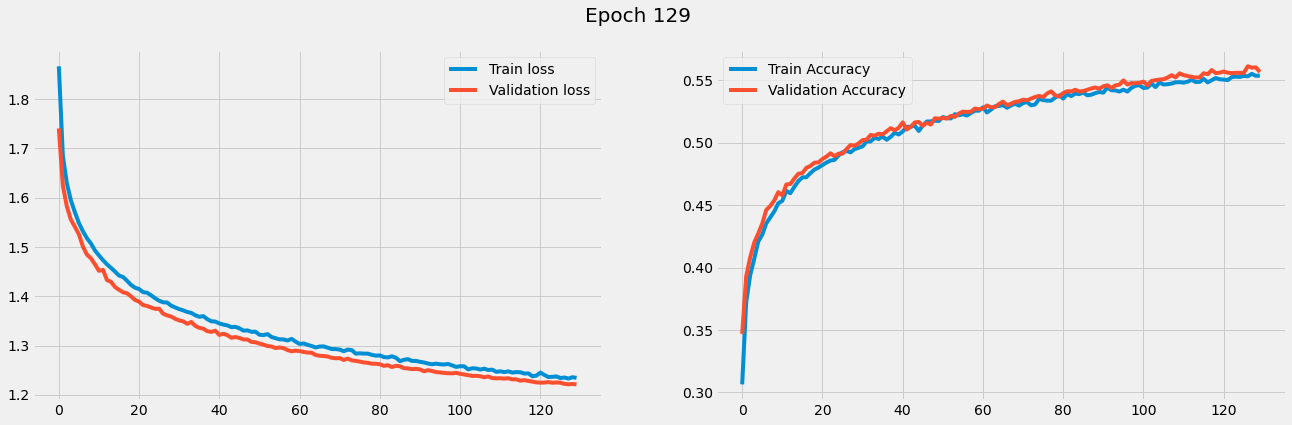

2.48 hours


In [49]:
optimizer = SGD_AdaptiveLR(model.parameters(), lr = 0.15, weight_decay=5e-4)
run_experiment(model, optimizer)